## aim of the notebook

This notebook is used to preprocess the different datasets, cluster and identify the number of reads/cell for the common markers in the common populations

### import packages

In [14]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import xb.plotting as xp
import os 

We will apply the same preprocessing as we did for Xenium to the CosMx,Hybriss, Vizgen and ResolvedBio

In [33]:
def main_preprocessing(adata):
    print(adata.shape)
    adata.layers['raw']=adata.X.copy()
    sc.pp.filter_cells(adata,min_counts=10)
    sc.pp.filter_cells(adata,min_genes=3)
    print(adata.shape)
    adata.raw=adata
    adata.layers['raw']=adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)
    sc.pp.neighbors(adata, n_neighbors=8, n_pcs=0)
    sc.tl.leiden(adata,resolution=2.2,key_added='leiden_2_2')
    sc.tl.leiden(adata,resolution=1.4,key_added='leiden_1_4')
    sc.tl.leiden(adata,resolution=0.6,key_added='leiden_0_6')
    sc.tl.umap(adata,min_dist=0.1)
    return adata
    

In [34]:
path = '../../figures/2.comparison_between_datasets/with_regional_anno_segmented/'
files = os.listdir(path)
outpath='../../figures/2.comparison_between_datasets/preprocessed_for_comparison_segmented/'

In [36]:
files=files[1:]

In [38]:
for f in files:
    ad=sc.read(path+f)
    ad_preprocess=main_preprocessing(ad)
    ad_preprocess.write(outpath+f)

(39462, 960)
(37384, 960)
(27417, 49)
(9584, 49)
(2736, 268)
(2165, 268)
(23457, 128)
(21486, 128)
(75077, 649)
(68328, 649)
(111962, 541)
(110601, 541)


# Compare clusters

In [180]:
files=os.listdir(outpath)
genenames=[]

In [181]:
adata_dict={}
for f in files:
    ad=sc.read(outpath+f)
    ad.var.index=ad.var.index.map(str.lower)
    genenames=genenames+list(ad.var.index)
    adata_dict[f.split('.')[0]]=ad
genenames=np.unique(genenames)

In [182]:
repeated=[]
for variable in genenames:
    #print(variable)
    rep=0
    for key in adata_dict.keys():
        if variable in adata_dict[key].var.index: 
            rep = rep+1
    repeated.append(rep)
import pandas as pd
df = pd.DataFrame(repeated)
df.index= genenames
df_filt = df[df[0] > 3]

anno_CosMx


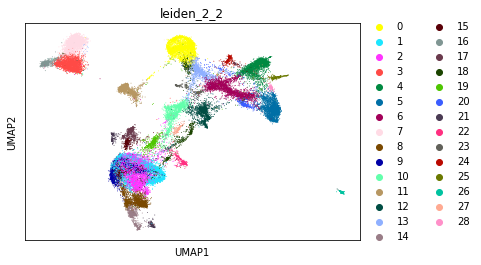

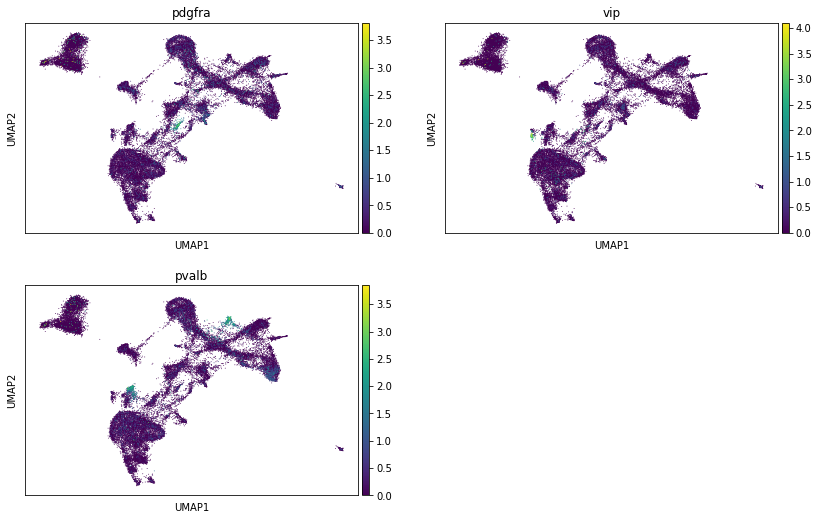

anno_Hybriss


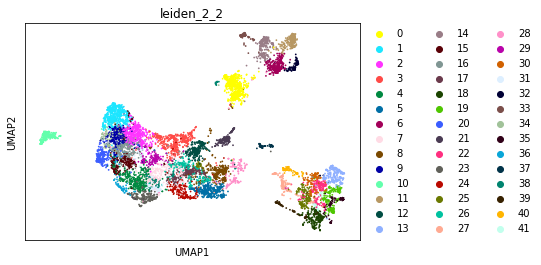

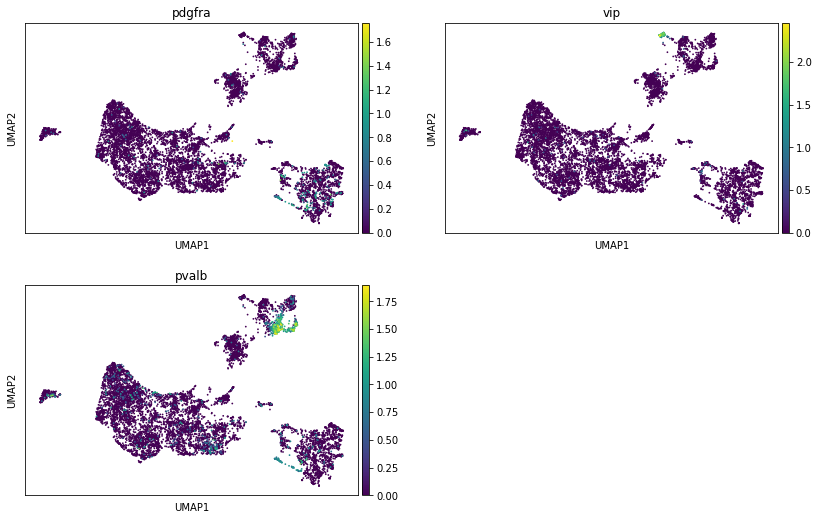

anno_MERFISH


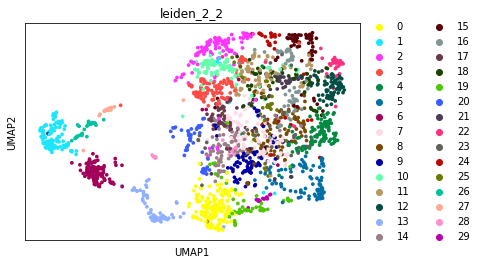

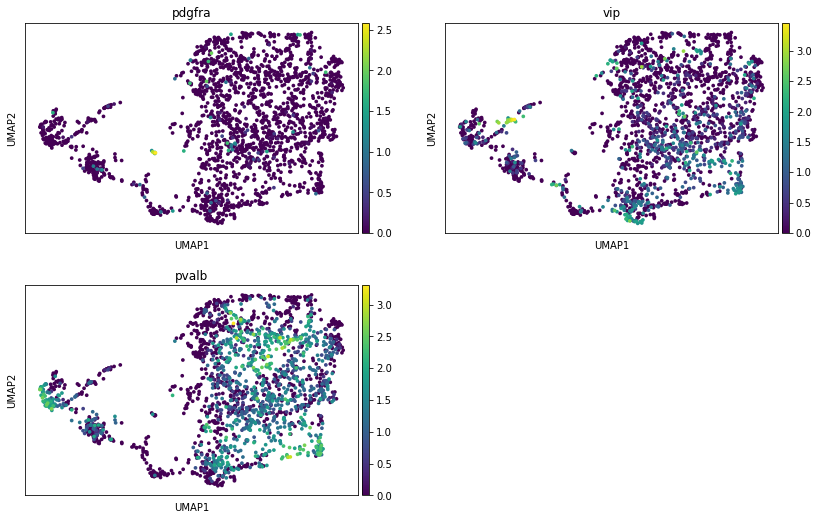

anno_ResolveBio


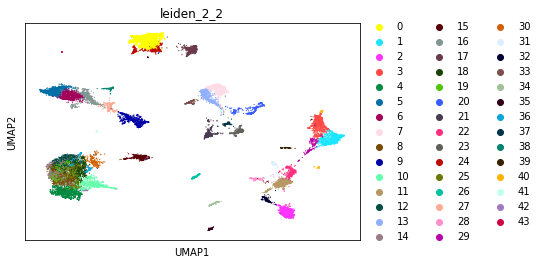

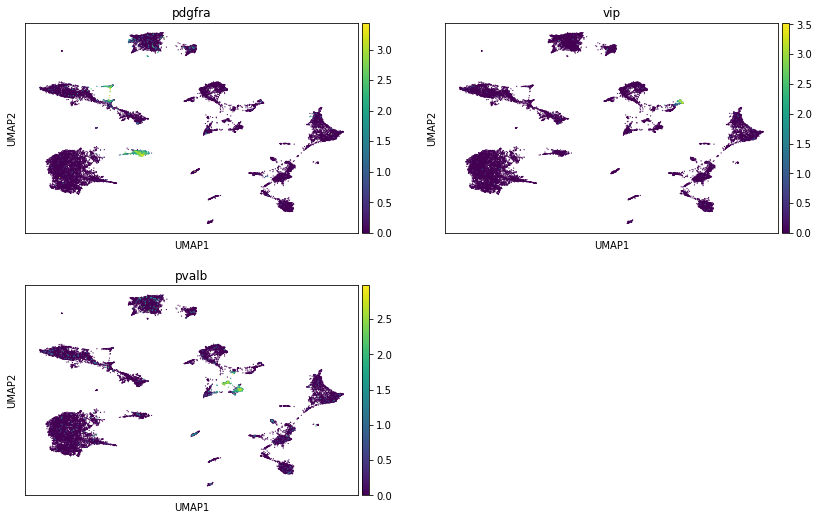

anno_Vizgen


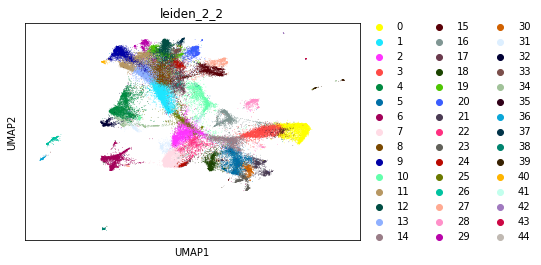

notposs
anno_Xenium


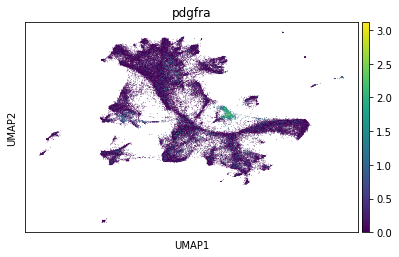

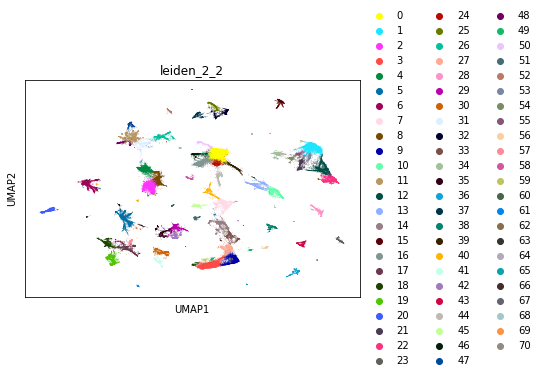

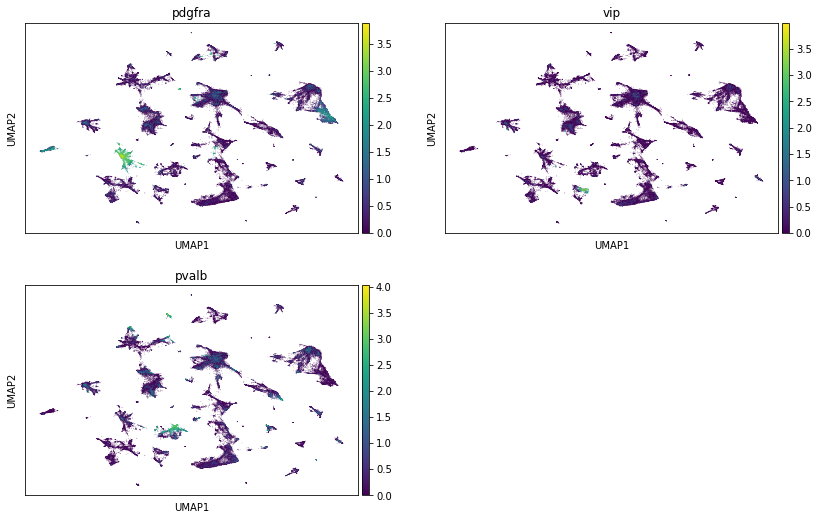

In [186]:
for k in adata_dict.keys():
    print(k)
    try:
        adata_dict[k].raw.var.index=adata_dict[k].raw.var.index.map(str.lower)
    except:
        print()
    try:
        adata_dict[k].obs['leiden_2_2']=adata_dict[k].obs['leiden_2_2'].astype(str)
        sc.pl.umap(adata_dict[k],color=['leiden_2_2'],use_raw=False)
        sc.pl.umap(adata_dict[k],color=['pdgfra','vip','pvalb'],ncols=2,use_raw=False)
        plt.show()
    except:
        print('notposs')

In [165]:
def expression_of_all_genes(adata_dict,clusters,markers):
    output_list=[]
    for k in adata_dict.keys():
        print(k)
        try:
            adata_dict[k].raw.var.index=adata_dict[k].raw.var.index.map(str.lower)
        except:
            print()
        adata_dict[k].obs['leiden_1_4']=adata_dict[k].obs['leiden_1_4'].astype(int)
        asub=adata_dict[k]#[adata_dict[k].obs['leiden_1_4'].isin(clusters[k])]
        asub.obs['leiden_1_4']=asub.obs['leiden_1_4'].astype(str)
        #sc.pl.spatial(asub,spot_size=40,color='leiden_1_4')
        out=pd.DataFrame(np.sum(adata_dict[k].layers['raw']>0,axis=1))
        out['dataset']=k
        output_list.append(out)
    markers_ct=pd.concat(output_list)
    return markers_ct

In [166]:
def expression_of_all_markers(adata_dict,clusters,markers):
    output_list=[]
    for k in adata_dict.keys():
        print(k)
        try:
            adata_dict[k].raw.var.index=adata_dict[k].raw.var.index.map(str.lower)
        except:
            print()
        adata_dict[k].obs['leiden_1_4']=adata_dict[k].obs['leiden_1_4'].astype(int)
        asub=adata_dict[k]#[adata_dict[k].obs['leiden_1_4'].isin(clusters[k])]
        asub.obs['leiden_1_4']=asub.obs['leiden_1_4'].astype(str)
        #sc.pl.spatial(asub,spot_size=40,color='leiden_1_4')
        out=pd.DataFrame(np.sum(adata_dict[k].layers['raw'],axis=1))
        out['dataset']=k
        output_list.append(out)
    markers_ct=pd.concat(output_list)
    return markers_ct

In [72]:
markers_ct=expression_of_all_markers(adata_dict,[],[])

anno_CosMx
anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium


In [167]:
genes_ct=expression_of_all_genes(adata_dict,[],[])

anno_CosMx
anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium


In [169]:
vals=np.sum(adata_dict['anno_CosMx'].layers['raw'],axis=1)
np.percentile(np.sum(adata_dict['anno_CosMx'].layers['raw'],axis=1),95)
order=markers_ct.groupby('dataset').max().sort_values(by=0).index
markers_ct[0]=markers_ct[0].astype(int)
#markers_ct.reset_index(inplace=True)

In [161]:
color_dicitonary = {
'anno_scRNAseq': 'black',
 'anno_starmap': 'red',
 'anno_allen_smfish': 'purple',
 'anno_MERFISH': '#9EE493',
    'anno_Hybriss': '#e82a92',
 'anno_osmfish': 'yellow',
 #'anno_seqFISH': 'cyan',
 'anno_exseq': 'brown',
 'anno_Vizgen': '#2E5077',
 'anno_baristaseq': 'orange',
 'anno_Xenium':'#56018f',
'anno_ResolveBio':'#4DA1A9', 
    'anno_CosMx':'#FFA630'}
coli=[color_dicitonary[el] for el in order]

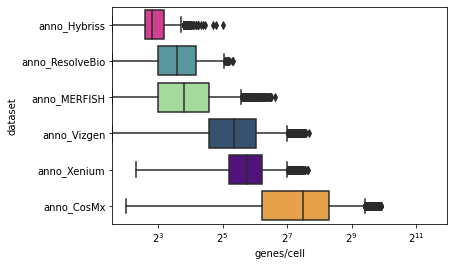

In [172]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig,ax=plt.subplots()
sns.boxplot(data=genes_ct,x=0,y='dataset',order=order,palette=coli)
plt.xlim([3,4000])
#plt.yscale('log')
#plt.set_xscale('log',base=2)
plt.xlabel('genes/cell')
ax.set_xscale('log', base=2)
plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/genes_by_cell_allmethods_boxplot.pdf')

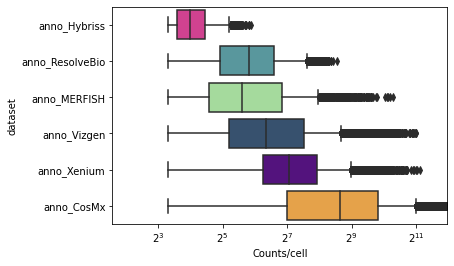

In [173]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig,ax=plt.subplots()
sns.boxplot(data=markers_ct,x=0,y='dataset',order=order,palette=coli)
plt.xlim([3,4000])
#plt.yscale('log')
#plt.set_xscale('log',base=2)
plt.xlabel('Counts/cell')
ax.set_xscale('log', base=2)
plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/reads_by_cell_allmethods_boxplot.pdf')

/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try ecdfplot.
  warnings.warn(msg, UserWarning)


(0.0, 30000.0)

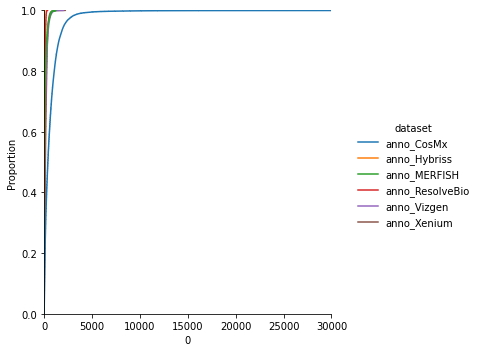

In [106]:
sns.displot(data=markers_ct,x=0,hue='dataset',kind='ecdf',ax=ax)
plt.xlim([0,30000])
#plt.set_xscale('log',base=2)

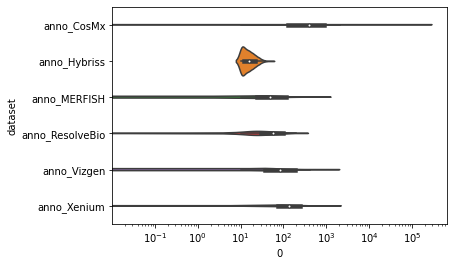

In [77]:
#GFAP plot
sns.violinplot(data=markers_ct,y='dataset',x=0)
plt.xscale('log')
#plt.xlim([0,500])

# Astrocyte clusters

In [48]:
adata_dict.keys()

dict_keys(['anno_CosMx', 'anno_Hybriss', 'anno_MERFISH', 'anno_ResolveBio', 'anno_Vizgen', 'anno_Xenium'])

In [49]:
astrocyte_clusters={'anno_CosMx':[18],'anno_Hybriss':[26],'anno_MERFISH':[18] ,'anno_Xenium':[7], 'anno_ResolveBio':[15,29], 'anno_Vizgen':[15]}
astro_markers=['pdgfra']

In [220]:
def expression_of_markers(adata_dict,clusters,markers):
    output_list=[]
    for k in adata_dict.keys():
        try:
            print(k)
            try:
                adata_dict[k].raw.var.index=adata_dict[k].raw.var.index.map(str.lower)
            except:
                print()
            adata_dict[k].obs['leiden_2_2']=adata_dict[k].obs['leiden_2_2'].astype(int)
            expi=adata_dict[k].to_df()
            expi['leiden_2_2']=adata_dict[k].obs['leiden_2_2']
            meanexpi=expi.groupby('leiden_2_2').mean()
            gn=markers[0]
            goodclust=meanexpi.loc[:,gn].idxmax()
            asub=adata_dict[k][adata_dict[k].obs['leiden_2_2'].isin([goodclust])]
            asub.obs['leiden_2_2']=asub.obs['leiden_2_2'].astype(str)
            #sc.pl.spatial(asub,spot_size=40,color='leiden_1_4')
            out=asub.to_df().loc[:,markers]
            out['dataset']=k
            output_list.append(out)
        except:
            print('not poss')
    markers_ct=pd.concat(output_list)
    return markers_ct

In [211]:
markers_ct=expression_of_markers(adata_dict,astrocyte_clusters,astro_markers)

anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:16: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium


anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium
not poss
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium
anno_CosMx
not poss
anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
anno_Xenium
not poss
anno_CosMx
not poss
anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


not poss
anno_Xenium
anno_CosMx
not poss
anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
not poss
anno_ResolveBio
anno_Vizgen
anno_Xenium
anno_CosMx
not poss
anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
anno_Vizgen


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
anno_Xenium
anno_CosMx
not poss
anno_Hybriss
anno_MERFISH
anno_ResolveBio
anno_Vizgen


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


not poss
anno_Xenium


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == "__main__":


anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
anno_Xenium
not poss
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
anno_MERFISH
anno_ResolveBio
not poss
anno_Vizgen
not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
not poss
anno_Xenium
anno_CosMx


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  app.launch_new_instance()


anno_Hybriss
not poss
anno_MERFISH
anno_ResolveBio
anno_Vizgen
anno_Xenium
not poss


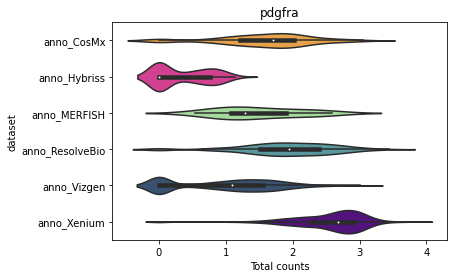

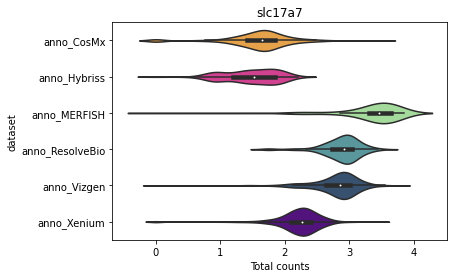

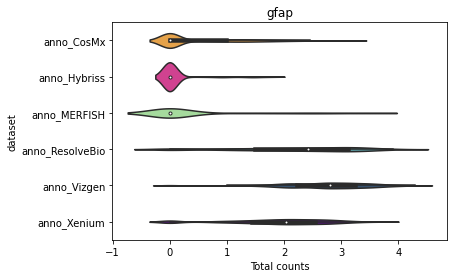

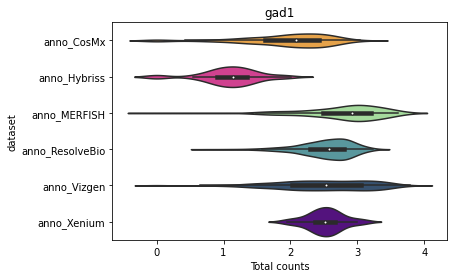

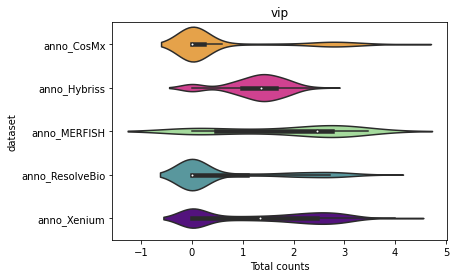

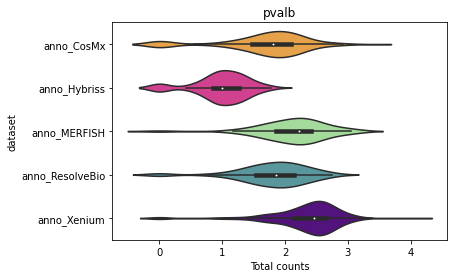

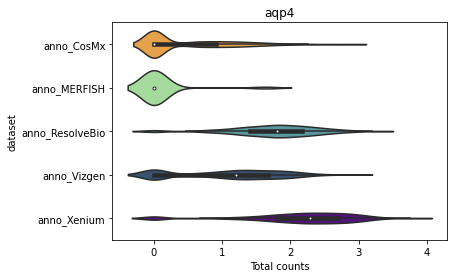

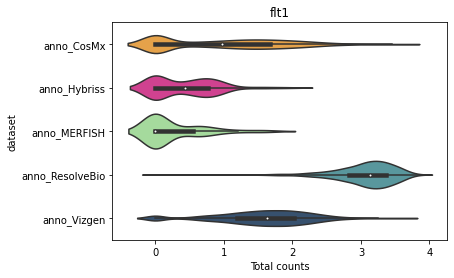

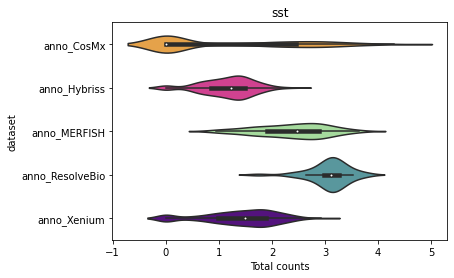

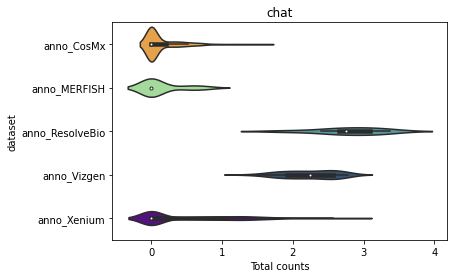

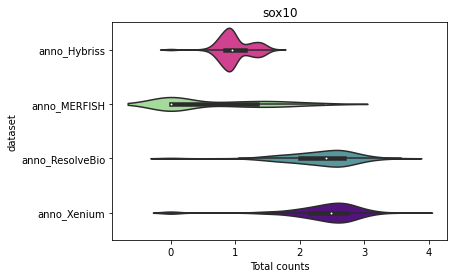

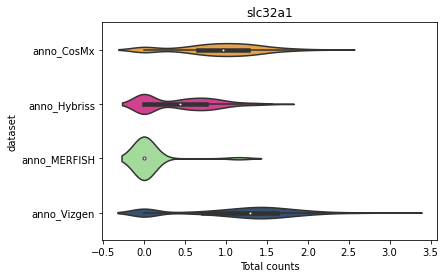

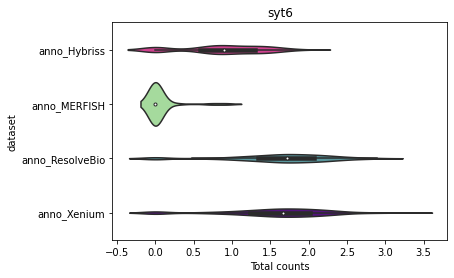

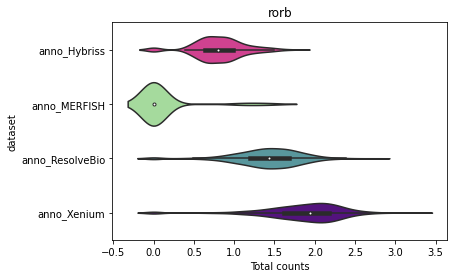

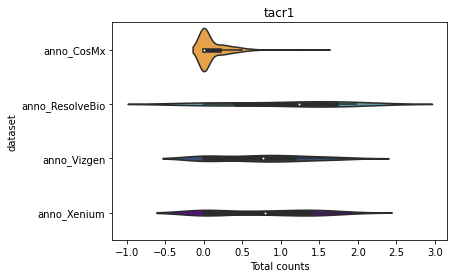

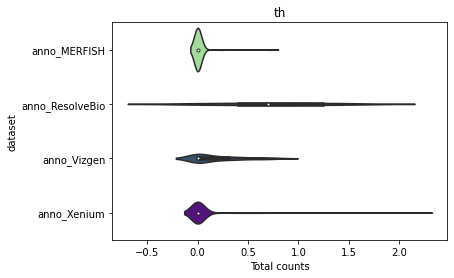

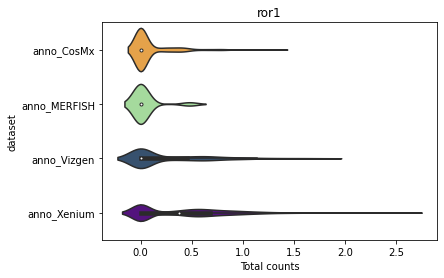

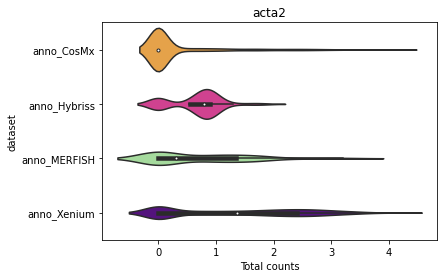

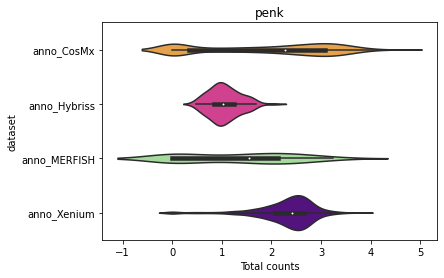

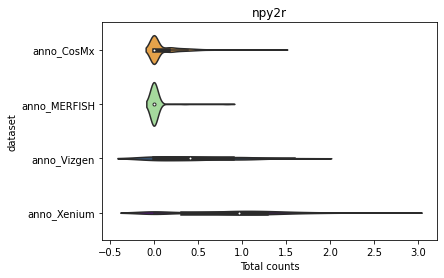

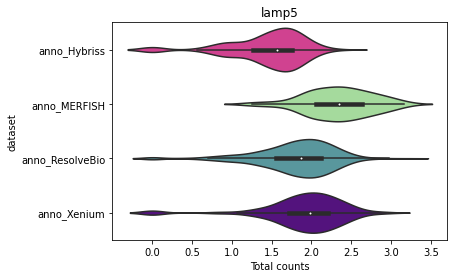

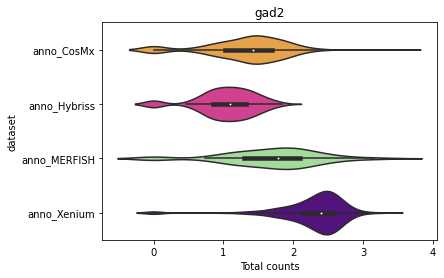

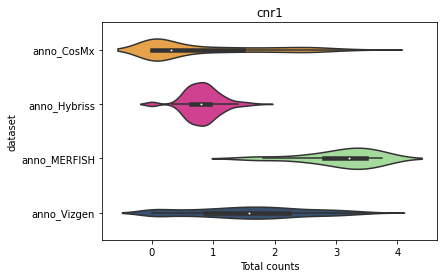

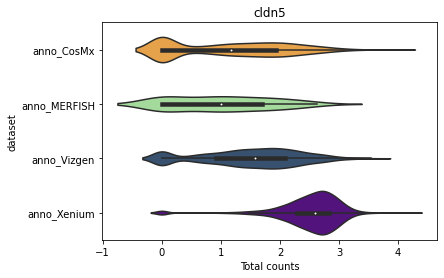

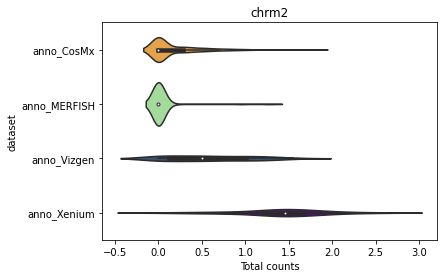

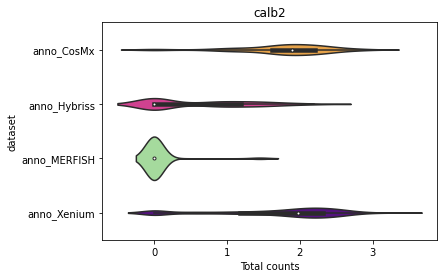

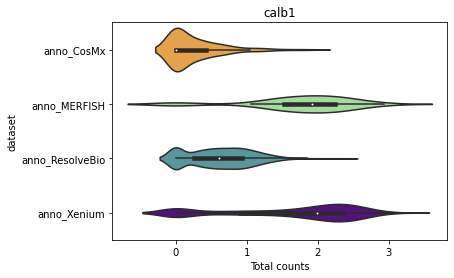

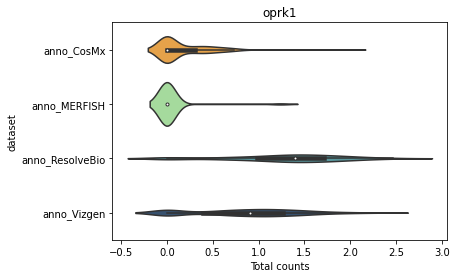

In [232]:
for gg in df_filt.sort_values(by=0,ascending=False).head(40).index:
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    mark=[gg]
    markers_ct=expression_of_markers(adata_dict,astrocyte_clusters,mark)
    pal=[color_dicitonary[c] for c in np.unique(markers_ct['dataset'])]
    #GFAP plot
    plt.figure()
    sns.violinplot(data=markers_ct,y='dataset',x=mark[0],palette=pal)
    plt.title(gg)
    plt.xlabel('Total counts')
    plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/gene_specific_cluster_expression_'+str(gg)+'.pdf')

<AxesSubplot:xlabel='aqp4', ylabel='dataset'>

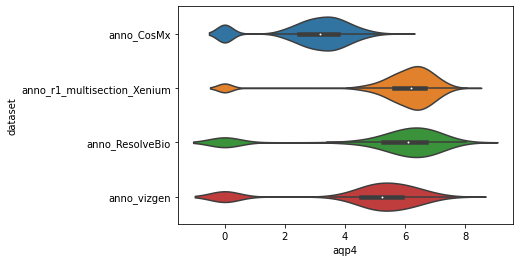

In [202]:
#AQP4 plot
sns.violinplot(data=markers_ct,y='dataset',x='aqp4')

# OPCs

In [209]:
OPC_clusters={'anno_CosMx':[16], 'anno_r1_multisection_Xenium':[9], 'anno_ResolveBio':[16], 'anno_vizgen':[13]}
OPC_markers=['pdgfra']

In [210]:
markers_ct=expression_of_markers(adata_dict,OPC_clusters,OPC_markers)

anno_CosMx
anno_r1_multisection_Xenium
anno_ResolveBio
anno_vizgen


/home/sergio/anaconda3/envs/xb/lib/python3.7/site-packages/ipykernel_launcher.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  # This is added back by InteractiveShellApp.init_path()


<AxesSubplot:xlabel='pdgfra', ylabel='dataset'>

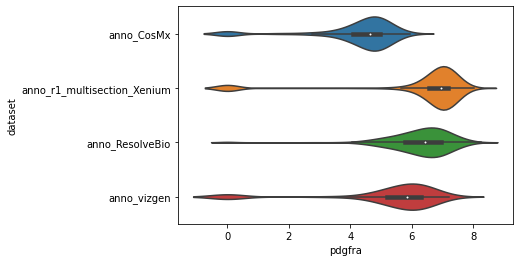

In [211]:
#GFAP plot
sns.violinplot(data=markers_ct,y='dataset',x='pdgfra')